# Scoring poses using RDKit feature maps

SuCOS allows to score individal pairs of molecules, but we want a method that determines how well a docked pose aligns to the fragment hits in general.

The hypothesis followed here is that it is the set of features, not the shape, that is critical. e.g. what's important is whether a pose forms a H-bond, not the exact shape of the molcule that provides the H-bond donor/acceptor.

Therefore we use the feature maps of the existing fragment hits to build a set of feature maps. Each map can be used individually to score a pose, but the key concept explored here is merging those feature maps into a single 'Frankenstein' feature map and using that to score poses. This approach should allow to score how well a pose corresponds to the set of interactions that we know are important for binding.

The core technology used is RDKit's feature map functionality, and most importantly the `CombineFeatMaps()` function.

In [1]:
import os, gzip, pickle

import pandas as pd
import numpy as np

from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools

from rdkit import Chem, rdBase, RDConfig
from rdkit.Chem import AllChem, rdShapeHelpers
from rdkit.Chem.FeatMaps import FeatMaps, FeatMapUtils
from rdkit.Chem.FeatMaps.FeatMapUtils import CombineFeatMaps

import plotly.express as px
import plotly.express as px
import plotly.io as pio

In [2]:
# Set the default renderer to png as the data is huge and overwhelms the Javascript renderers
pio.renderers.default = 'png'

In [3]:
# This is pretty well exact copy and paste from the SuCOS code in the Squonk Pipelines project:
# https://github.com/InformaticsMatters/pipelines/blob/master/src/python/pipelines/rdkit/sucos.py
# This code needs improving!!!

# Setting up the features to use in FeatureMap
ffact = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

fmParams = {}
for k in ffact.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')

def filterFeature(f):
    result = f.GetFamily() in keep
    # TODO - nothing ever seems to be filtered. Is this expected?
    #if not result:
    #    print("Filtered out feature type", f.GetFamily())
    return result

def getRawFeatures(mol):
    rawFeats = ffact.GetFeaturesForMol(mol)
    # filter that list down to only include the ones we're interested in
    filtered = list(filter(filterFeature, rawFeats))
    return filtered

def getFeatureMap(mol):
    feats = getRawFeatures(mol)
    return FeatMaps.FeatMap(feats=feats, weights=[1]*len(feats),params=fmParams)

def gen_feats(mol):
    rawFeats = getRawFeatures(mol)
    return FeatMaps.FeatMap(feats=feats, weights=[1]*len(rawFeats), params=fmParams)

def get_FeatureMapScore(small_feats, large_feats, tani=False, score_mode=FeatMaps.FeatMapScoreMode.All):
    """
    Generate the feature map score.

    :param small_feats:
    :param large_feats:
    :param tani:
    :return:
    """

    featLists = []
    for rawFeats in [small_feats, large_feats]:
        # filter that list down to only include the ones we're interested in
        featLists.append(rawFeats)
    fms = [FeatMaps.FeatMap(feats=x, weights=[1] * len(x), params=fmParams) for x in featLists]
    # set the score mode
    fms[0].scoreMode = score_mode

    try:
        if tani:
            c = fms[0].ScoreFeats(featLists[1])
            A = fms[0].GetNumFeatures()
            B = len(featLists[1])
            if B != fms[1].GetNumFeatures():
                print("Why isn't B equal to number of features...?!")
            tani_score = float(c) / (A+B-c)
            return tani_score
        else:
            fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
            return fm_score
    except ZeroDivisionError:
        print("ZeroDivisionError")
        return 0

    if tani:
        tani_score = float(c) / (A+B-c)
        return tani_score
    else:
        fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
        return fm_score

def get_SucosScore(ref_mol, query_mol, tani=False, ref_features=None, query_features=None, score_mode=FeatMaps.FeatMapScoreMode.All):
    """
    This is the key function that calculates the SuCOS scores and is expected to be called from other modules.
    To improve performance you can pre-calculate the features and pass them in as optional parameters to avoid having
    to recalculate them. Use the getRawFeatures function to pre-calculate the features.

    :param ref_mol: The reference molecule to compare to
    :param query_mol: The molecule to compare to the reference
    :param tani: Whether to calculate Tanimoto distances
    :param ref_features: An optional feature map for the reference molecule, avoiding the need to re-calculate it.
    :param query_features: An optional feature map for the query molecule, avoiding the need to re-calculate it.
    :return: A tuple of 3 values. 1 the sucos score, 2 the feature map score,
        3 the Tanimoto distance or 1 minus the protrude distance
    """

    if not ref_features:
        ref_features = getRawFeatures(ref_mol)
    if not query_features:
        query_features = getRawFeatures(query_mol)

    fm_score = get_FeatureMapScore(ref_features, query_features, tani, score_mode)
    fm_score = np.clip(fm_score, 0, 1)

    try :
        if tani:
            tani_sim = 1 - float(rdShapeHelpers.ShapeTanimotoDist(ref_mol, query_mol))
            tani_sim = np.clip(tani_sim, 0, 1)
            SuCOS_score = 0.5*fm_score + 0.5*tani_sim
            return SuCOS_score, fm_score, tani_sim
        else:
            protrude_dist = rdShapeHelpers.ShapeProtrudeDist(ref_mol, query_mol, allowReordering=False)
            protrude_dist = np.clip(protrude_dist, 0, 1)
            protrude_val = 1.0 - protrude_dist
            SuCOS_score = 0.5 * fm_score + 0.5 * protrude_val
            return SuCOS_score, fm_score, protrude_val
    except:
        utils.log("Failed to calculate SuCOS scores. Returning 0,0,0")
        return 0, 0, 0

In [4]:
# Read the 22 non-covalent hits
supplr = Chem.ForwardSDMolSupplier(gzip.open('Mpro_22_data/hits-22.sdf.gz'))
hits = [m for m in supplr]
len(hits)

22

In [5]:
# Quick test that we can generate scores
mol0 = hits[0]
i = 0
for mol1 in hits:
    score = get_SucosScore(mol0, mol1)
    print('Scores for ', i, ' = ', score)
    i += 1

Scores for  0  =  (1.0, 1.0, 1.0)
Scores for  1  =  (0.3354478610833468, 0.28154904765227323, 0.3893466745144203)
Scores for  2  =  (0.04892741698501324, 0.0, 0.09785483397002648)
Scores for  3  =  (0.17079093778189738, 0.0002980121951257837, 0.341283863368669)
Scores for  4  =  (0.1961072928859393, 0.0008718295881330303, 0.3913427561837456)
Scores for  5  =  (0.28794168228654904, 0.17134594559843694, 0.4045374189746611)
Scores for  6  =  (0.17971886144375557, 0.021016824736645283, 0.33842089815086585)
Scores for  7  =  (0.5339963436165014, 0.35332759428523064, 0.7146650929477723)
Scores for  8  =  (0.39738405803265153, 0.05699557628922757, 0.7377725397760755)
Scores for  9  =  (0.004115226337448541, 0.0, 0.008230452674897082)
Scores for  10  =  (0.0, 0.0, 0.0)
Scores for  11  =  (0.3531590064870713, 0.2745198316893083, 0.43179818128483427)
Scores for  12  =  (0.0, 0.0, 0.0)
Scores for  13  =  (0.27478377982074803, 0.1981524653018735, 0.3514150943396226)
Scores for  14  =  (0.395816786

In [6]:
# let's compare the overlaps
i = 0
names = []
sucos_data = {}
feat_data = {}
for mol1 in hits:
    j = 0
    name = mol1.GetProp('_Name')[5:-2]
    names.append(name)
    sucos_scores = []
    feat_scores = []
    for mol2 in hits:
        scores = get_SucosScore(mol1, mol2)
        sucos_scores.append(scores[0])
        feat_scores.append(scores[1])
        j += 1
    i += 1
    sucos_data[name] = sucos_scores
    feat_data[name] = feat_scores
df_sucos = pd.DataFrame(sucos_data)
df_feats = pd.DataFrame(feat_data)
df_sucos.shape

(22, 22)

In [7]:
df_feats.shape

(22, 22)

In [8]:
df_sucos.head()

,x0072,x0104,x0107,x0161,x0195,x0305,x0354,x0387,x0395,x0397,...,x0540,x0678,x0874,x0946,x0967,x0991,x0995,x1077,x1093,x1249
0,1.000000,0.312263,0.062250,0.167198,0.177765,0.334046,0.139475,0.542620,0.381322,0.004512,...,0.000000,0.249277,0.397471,0.152159,0.113043,0.317983,0.000000,0.276186,0.142904,0.290930
1,0.335448,1.000000,0.037395,0.482330,0.499495,0.346940,0.105180,0.286389,0.269690,0.000000,...,0.000000,0.183649,0.326123,0.531504,0.072070,0.000710,0.000000,0.046884,0.133120,0.296291
2,0.048927,0.026507,1.000000,0.022851,0.019527,0.039574,0.010721,0.034509,0.066940,0.283256,...,0.384432,0.622295,0.180489,0.009247,0.412275,0.002835,0.473616,0.093707,0.489700,0.062743
3,0.170791,0.448959,0.028380,1.000000,0.649047,0.192675,0.085130,0.149961,0.166573,0.000133,...,0.000000,0.133390,0.190586,0.883936,0.087891,0.000000,0.000000,0.033196,0.125989,0.146602
4,0.196107,0.493949,0.026968,0.681003,1.000000,0.268035,0.142761,0.193219,0.188687,0.000000,...,0.000000,0.141632,0.206632,0.772596,0.074081,0.001054,0.000000,0.057346,0.137522,0.174902


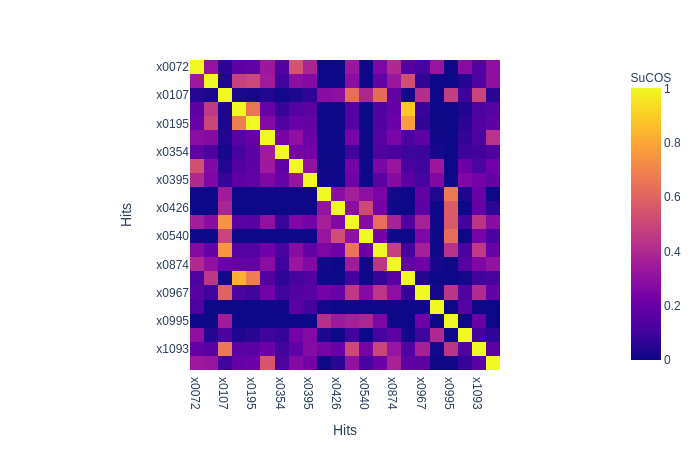

In [9]:
# So how does this look? First the SuCOS score
fig = px.imshow(df_sucos, labels=dict(x="Hits", y="Hits", color="SuCOS"), x=names, y=names)
fig.show()
# As expexcted some hits overlap to a differing degree

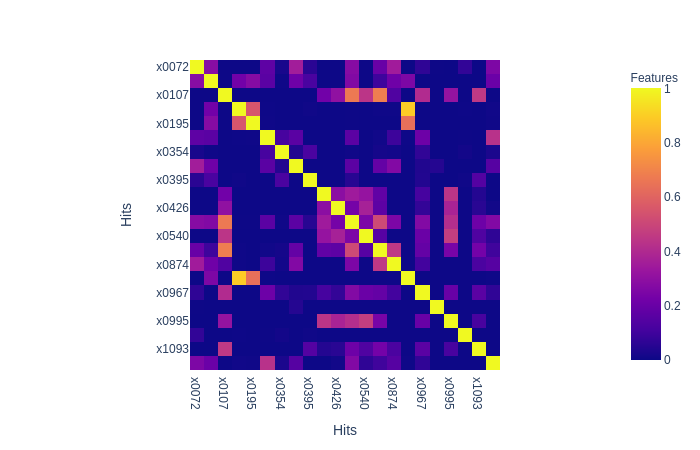

In [10]:
# Now just the features
fig = px.imshow(df_feats, labels=dict(x="Hits", y="Hits", color="Features"), x=names, y=names)
fig.show()

# Combining and merging feature maps

In [11]:
# combining 2 feature maps (no merge)
feat0 = getFeatureMap(hits[0])
feat1 = getFeatureMap(hits[1])
merged = CombineFeatMaps(feat0, feat1)
print(feat0)
print(feat1)
print(merged)
# 7 + 10 = 17
# feature maps combined but not merged

  1        Donor  8.4960 -3.4980  24.5920  1.0000
  2     Acceptor  7.1910 -5.0190  26.2290  1.0000
  3     Acceptor  8.4340 -3.4430  27.2120  1.0000
  4     Aromatic  12.0743 -0.3665  23.1487  1.0000
  5   Hydrophobe  10.8760 -1.0500  23.1440  1.0000
  6   Hydrophobe  9.5680 -1.8260  23.1510  1.0000
  7 LumpedHydrophobe  12.0743 -0.3665  23.1487  1.0000

  1        Donor  12.0740  5.3880  23.6220  1.0000
  2        Donor  10.5720  1.3010  24.5250  1.0000
  3     Acceptor  10.4660  6.3160  24.8740  1.0000
  4     Acceptor  13.7690 -1.8980  21.4040  1.0000
  5     Aromatic  11.4848  1.4778  23.8542  1.0000
  6     Aromatic  12.0783 -0.4323  23.0108  1.0000
  7   Hydrophobe  12.2100  2.3170  23.4570  1.0000
  8   Hydrophobe  12.2670  0.9460  23.1470  1.0000
  9   Hydrophobe  13.1760  3.3750  22.9180  1.0000
 10 LumpedHydrophobe  12.0783 -0.4323  23.0108  1.0000

  1        Donor  8.4960 -3.4980  24.5920  1.0000
  2     Acceptor  7.1910 -5.0190  26.2290  1.0000
  3     Acceptor  8.4340 -3

In [12]:
# combining 2 feature maps (with merge)
feat0 = getFeatureMap(hits[0])
feat1 = getFeatureMap(hits[1])
merged = CombineFeatMaps(feat0, feat1, mergeMetric=1, mergeTol=1.5, dirMergeMode=1)
print(feat0)
print(feat1)
print(merged)
# we get 2 less features. Something is being merged!

  1        Donor  8.4960 -3.4980  24.5920  1.0000
  2     Acceptor  7.1910 -5.0190  26.2290  1.0000
  3     Acceptor  8.4340 -3.4430  27.2120  1.0000
  4     Aromatic  12.0743 -0.3665  23.1487  1.0000
  5   Hydrophobe  10.8760 -1.0500  23.1440  1.0000
  6   Hydrophobe  9.5680 -1.8260  23.1510  1.0000
  7 LumpedHydrophobe  12.0743 -0.3665  23.1487  1.0000

  1        Donor  12.0740  5.3880  23.6220  1.0000
  2        Donor  10.5720  1.3010  24.5250  1.0000
  3     Acceptor  10.4660  6.3160  24.8740  1.0000
  4     Acceptor  13.7690 -1.8980  21.4040  1.0000
  5     Aromatic  11.4848  1.4778  23.8542  1.0000
  6     Aromatic  12.0783 -0.4323  23.0108  1.0000
  7   Hydrophobe  12.2100  2.3170  23.4570  1.0000
  8   Hydrophobe  12.2670  0.9460  23.1470  1.0000
  9   Hydrophobe  13.1760  3.3750  22.9180  1.0000
 10 LumpedHydrophobe  12.0783 -0.4323  23.0108  1.0000

  1        Donor  8.4960 -3.4980  24.5920  1.0000
  2     Acceptor  7.1910 -5.0190  26.2290  1.0000
  3     Acceptor  8.4340 -3

In [13]:
# simplistic merging - merge in the order the molecules are in the file
featMaps = []
total_feature_count = 0
for mol in hits:
    featMap = getFeatureMap(mol)
    print('Processing mol', mol.GetProp('_Name'), 'found', featMap.GetNumFeatures())
    total_feature_count += featMap.GetNumFeatures()
    featMaps.append(featMap)
print('Generated', total_feature_count, 'features')

merged_f = None
for featMap in featMaps:
    #print(featMap)
    if not merged_f:
        merged_f = featMap
    else:
        merged_f = CombineFeatMaps(merged_f, featMap,  mergeMetric=1, mergeTol=1.5, dirMergeMode=1)
        
print(merged_f)

# 156 features are merged down to 88.
    

Processing mol Mpro-x0072_0 found 7
Processing mol Mpro-x0104_0 found 10
Processing mol Mpro-x0107_0 found 5
Processing mol Mpro-x0161_0 found 9
Processing mol Mpro-x0195_0 found 7
Processing mol Mpro-x0305_0 found 4
Processing mol Mpro-x0354_0 found 8
Processing mol Mpro-x0387_0 found 7
Processing mol Mpro-x0395_0 found 6
Processing mol Mpro-x0397_0 found 5
Processing mol Mpro-x0426_0 found 10
Processing mol Mpro-x0434_0 found 7
Processing mol Mpro-x0540_0 found 7
Processing mol Mpro-x0678_0 found 7
Processing mol Mpro-x0874_0 found 8
Processing mol Mpro-x0946_0 found 7
Processing mol Mpro-x0967_0 found 12
Processing mol Mpro-x0991_0 found 3
Processing mol Mpro-x0995_0 found 4
Processing mol Mpro-x1077_0 found 3
Processing mol Mpro-x1093_0 found 12
Processing mol Mpro-x1249_0 found 8
Generated 156 features
  1        Donor  8.4960 -3.4980  24.5920  1.0000
  2     Acceptor  7.1910 -5.0190  26.2290  1.0000
  3     Acceptor  8.4485 -3.1780  26.7635  1.0000
  4     Aromatic  11.9191 -0.39

In [14]:
# see what happens if we reverse the order of the mols
featMaps = []
total_feature_count = 0
for mol in reversed(hits):
    featMap = getFeatureMap(mol)
    print('Processing mol', mol.GetProp('_Name'), 'found', featMap.GetNumFeatures())
    total_feature_count += featMap.GetNumFeatures()
    featMaps.append(featMap)
print('Generated', total_feature_count, 'features')

merged_r = None
for featMap in featMaps:
    #print(featMap)
    if not merged_r:
        merged_r = featMap
    else:
        merged_r = CombineFeatMaps(merged_r, featMap,  mergeMetric=1, mergeTol=1.5, dirMergeMode=1)
        
print(merged_r)

# still get 88 features.
# but the data is not identical, so beware.
    

Processing mol Mpro-x1249_0 found 8
Processing mol Mpro-x1093_0 found 12
Processing mol Mpro-x1077_0 found 3
Processing mol Mpro-x0995_0 found 4
Processing mol Mpro-x0991_0 found 3
Processing mol Mpro-x0967_0 found 12
Processing mol Mpro-x0946_0 found 7
Processing mol Mpro-x0874_0 found 8
Processing mol Mpro-x0678_0 found 7
Processing mol Mpro-x0540_0 found 7
Processing mol Mpro-x0434_0 found 7
Processing mol Mpro-x0426_0 found 10
Processing mol Mpro-x0397_0 found 5
Processing mol Mpro-x0395_0 found 6
Processing mol Mpro-x0387_0 found 7
Processing mol Mpro-x0354_0 found 8
Processing mol Mpro-x0305_0 found 4
Processing mol Mpro-x0195_0 found 7
Processing mol Mpro-x0161_0 found 9
Processing mol Mpro-x0107_0 found 5
Processing mol Mpro-x0104_0 found 10
Processing mol Mpro-x0072_0 found 7
Generated 156 features
  1        Donor  8.5420  0.5850  24.9250  1.0000
  2        Donor  6.4250  0.8450  23.8150  1.0000
  3     Acceptor  8.2640  2.3450  23.4580  1.0000
  4     Acceptor  3.2905  1.144

## Hierarchical merging

The order is important, so let's merge is a smarter way. We'll take an approach similar to multiple sequence alignment where you align the most similar sequences in a recursive manner.

Iteratively merge the features
- Score all features vs. all features
- Find the 2 most similar
- Merge them
- Remove the 2 that were merged and replace with the merged one
- Update the scores to include the scores of the merged feature with the other features
- Repeat until there is only one feature map remaining

In [15]:
def score_featmaps(fm1, fm2):
    "Generate the score for 2 feature maps"
    return fm1.ScoreFeats(fm2.GetFeatures()) / fm1.GetNumFeatures()

def build_feat_data(mols):
    "Build the feature maps and do the all vs. all comparison"
    fmaps = []
    scores = []
    for mol1 in mols:
        fm1 = getFeatureMap(mol1)
        fmaps.append(fm1)
        row = []
        for mol2 in mols:
            fm2 = getFeatureMap(mol2)
            score = score_featmaps(fm1, fm2)
            row.append(score)
            #print(len(data), len(row), score)
        scores.append(row)
    return fmaps, scores

def find_closest(scores):
    #print('Find closest for', len(scores), len(scores[0]))
    best_score = 0
    for i in range(len(scores)):
        for j in range(len(scores)):
            if i == j:
                continue
            score = scores[i][j]
            if score > best_score:
                best_score = score
                best_row = i
                best_col = j
    return best_score, best_row, best_col

def merge_feat_maps(fmaps, scores):
    "Merge the 2 closest feature maps, remove them form the data and replace with the merged feature map"
    best_score, best_row, best_col = find_closest(scores)
    #print(best_score, best_row, best_col)
    feat1 = fmaps[best_row]
    feat2 = fmaps[best_col]
    print('Merging', best_row, 'and', best_col, 'with score', best_score, '#features:', feat1.GetNumFeatures(), feat2.GetNumFeatures())
    merged = CombineFeatMaps(feat1, feat2, mergeMetric=1, mergeTol=1.5, dirMergeMode=1)
    # need to make sure we delete the biggest index first to avoid changing the smaller index 
    if best_row > best_col:
        a = best_row
        b = best_col
    else:
        a = best_col
        b = best_row
        
    #print('Initial:', len(fmaps), len(scores), ','.join([str(len(x)) for x in scores]))
    del fmaps[a]
    del fmaps[b]
    del scores[a]
    del scores[b]
    for row in scores:
        del row[a]
        del row[b]
        
    #print('Intermediate:', len(fmaps), len(scores), ','.join([str(len(x)) for x in scores]))
    
    merged_scores = []
    for i in range(len(fmaps)):
        fmap = fmaps[i]
        score1 = score_featmaps(fmap, merged)
        score2 = score_featmaps(merged, fmap)
        scores[i].append(score1)
        merged_scores.append(score2)
        
    fmaps.append(merged)
    merged_scores.append(score_featmaps(merged, merged))
    scores.append(merged_scores)
    
    #print('Final:', len(fmaps), len(scores), ','.join([str(len(x)) for x in scores]))

In [16]:
# run the merging

fmaps, scores = build_feat_data(hits)
#print(len(fmaps))
while len(fmaps) > 1:
    merge_feat_maps(fmaps, scores)
merged_fmap = fmaps[0]
fname = "featurestein-22.p"
pickle.dump( fmaps[0], open(fname, "wb" ))
print('Wrote merged feature map as pickle to', fname)

Merging 15 and 3 with score 0.8923258636920277 #features: 7 9
Merging 2 and 12 with score 0.6812557890268437 #features: 5 7
Merging 2 and 18 with score 0.6086204594190924 #features: 7 9
Merging 8 and 17 with score 0.5467078392431313 #features: 7 8
Merging 12 and 8 with score 0.46961296312303324 #features: 4 7
Merging 8 and 15 with score 0.4660499851430776 #features: 8 10
Merging 2 and 12 with score 0.4259491340405144 #features: 4 8
Merging 0 and 13 with score 0.39584735588967107 #features: 7 13
Merging 2 and 13 with score 0.3494880690393135 #features: 7 17
Merging 3 and 10 with score 0.3368308638309464 #features: 5 9
Merging 4 and 10 with score 0.2512775548724359 #features: 12 21
Merging 3 and 9 with score 0.2501922279038919 #features: 10 12
Merging 0 and 6 with score 0.21780434251930894 #features: 10 11
Merging 5 and 6 with score 0.20961994020336477 #features: 10 28
Merging 4 and 7 with score 0.2065541092254725 #features: 12 35
Merging 1 and 6 with score 0.17008050514708373 #features:

## Look at the 3D distribution of the merged features

In [17]:
def gen_feature_info(fmap):
    families = []
    x_pos = []
    y_pos = []
    z_pos = []
    for feat in fmap.GetFeatures():
        fam = feat.GetFamily()
        pos = feat.GetPos()
        families.append(fam)
        x_pos.append(pos.x)
        y_pos.append(pos.y)
        z_pos.append(pos.z)
    df_finfo = pd.DataFrame({'family':families, 'x':x_pos, 'y':y_pos, 'z':z_pos})
    return df_finfo

In [18]:
df_finfo = gen_feature_info(merged_fmap)
df_finfo.shape

(88, 4)

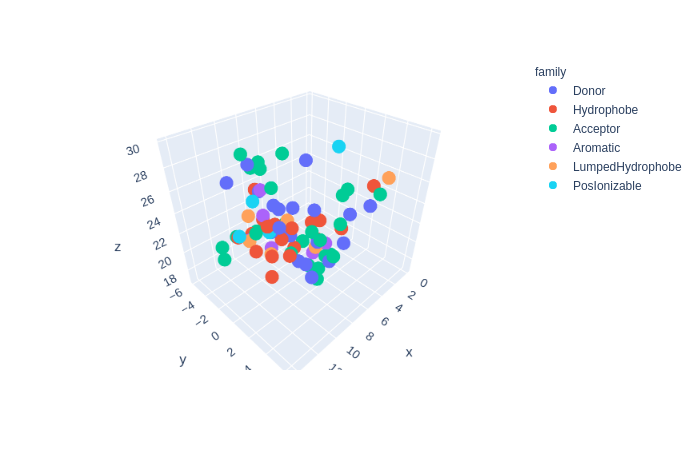

In [19]:
fig = px.scatter_3d(df_finfo, x='x', y='y', z='z', color='family')
fig.show()

In [20]:
# Let's just score some molecules - first the original hits.
# We'd expect them to all score close to 1

for featMap in featMaps:
    score = score_featmaps(featMap, merged_fmap)
    print(score)
    
# they do. All score ~1 so that's what we expect. 

0.9219208824002487
0.9702266296431356
1.0919584646821712
1.0699702574671257
1.050692850887956
0.9310638706431097
1.013837388841546
0.9578825446100362
0.8650628020986092
1.032443760168388
0.9172294593944853
0.9616587778698783
0.9963264185530456
0.9501077734747866
0.9754627589246238
0.9912248974947848
0.9525707355762163
0.9601394807685064
1.0187365040185652
0.9346781356342326
1.0455235522212647
1.0863040684025214


## Running predictions

In [21]:
# How about some candidates?
# These are a subset of Mpro-x0387 hit expanded and enumerate (charge states)
#   docked into Mpro-0387 using tethered docking. 
gz = gzip.open('tethering/Mpro-x0387_into_x0387_default_tether.sdf.gz')
supplr = Chem.ForwardSDMolSupplier(gz)
tethered_poses = []
count = 0
for m in supplr:
    if count % 40 == 0:
        tethered_poses.append(m)
    count += 1
len(tethered_poses)

296

In [22]:
def gen_sucos_scores(poses):
    i = 0
    data = {}
    x_names = []
    y_names = []

    for mol2 in poses:
        name = mol2.GetProp('_Name')
        y_names.append(name)

    for mol1 in hits:
        j = 0
        name = mol1.GetProp('_Name')
        x_names.append(name)
        scores = []
        for mol2 in poses:
            score = get_SucosScore(mol1, mol2)
            scores.append(score[0])
            mol2.SetDoubleProp('SuCOSScore', score)
            j += 1
        i += 1
        data[name] = scores
    dft = pd.DataFrame(data)
    print(dft.shape)
    print(len(x_names))
    print(len(y_names))

    return dft, x_names, y_names

In [23]:
# let's compare the individual overlaps
df_tethered, x_names_tethered, y_names_free = gen_sucos_scores(tethered_poses)

(296, 22)
22
296


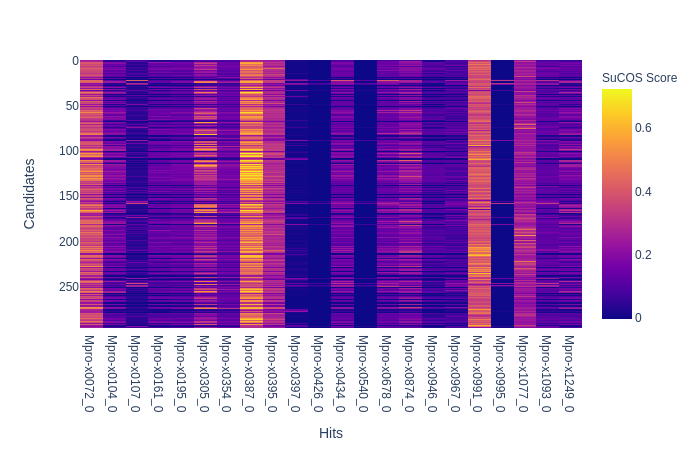

In [24]:
fig = px.imshow(df_tethered, labels=dict(x="Hits", y="Candidates", color="SuCOS Score"), x=x_names_tethered)
fig.show()

# Not surprisingly Mpro-x0387 scores best as that's what these ligands were tethered to when docked
# TODO - should we remove the originating hit from the comparison?

In [35]:
def gen_fmap_scores(poses):
    count = 0
    scores = []
    for mol in poses:
        name = mol.GetProp('_Name')
        featMap = getFeatureMap(mol)
        score = score_featmaps(featMap, merged_fmap)
        scores.append(score)
        mol.SetDoubleProp('FeatureSteinScore', score)
        #print(count, name, mol.GetProp('SCORE.norm'), score)
        count += 1
    return pd.DataFrame({'scores': scores})

In [36]:
# look at the distribution of meged feature map scores
df3 = gen_fmap_scores(tethered_poses)

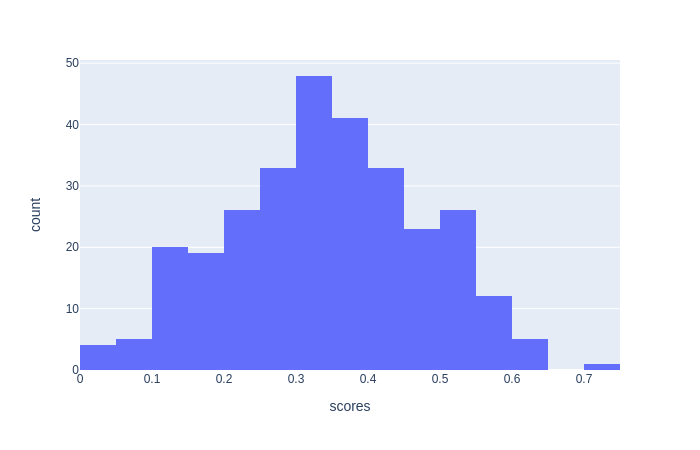

In [37]:
fig = px.histogram(df3,  x='scores')
fig.show()
# We get a reasonable distribution of scores
# Are they usefull?

In [38]:
# look at untethered docking
gz = gzip.open('tethering/Mpro-x0387_into_x0387_free.sdf.gz')
supplr = Chem.ForwardSDMolSupplier(gz)
free_poses = []
count = 0
for m in supplr:
    if count % 110 == 0:
        free_poses.append(m)
    count += 1
len(free_poses)

299

In [39]:
# let's compare the individual overlaps
df_free, x_names_free, y_names_free = gen_sucos_scores(free_poses)

(299, 22)
22
299


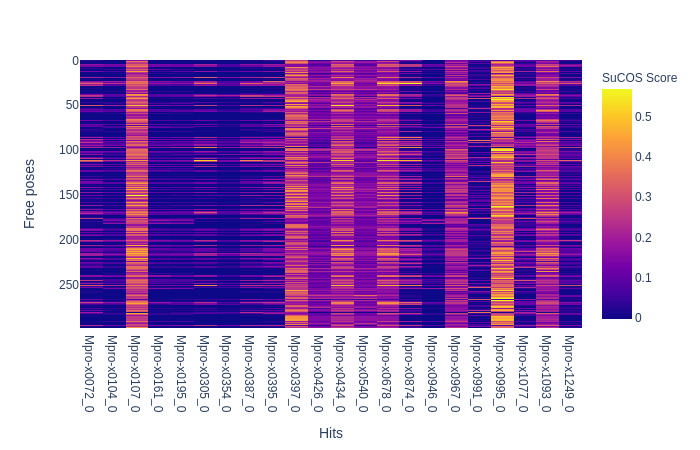

In [40]:
fig = px.imshow(df_free, labels=dict(x="Hits", y="Free poses", color="SuCOS Score"), x=x_names_free)
fig.show()

In [41]:
df_free_scores = gen_fmap_scores(free_poses)
df_free_scores.shape

(299, 1)

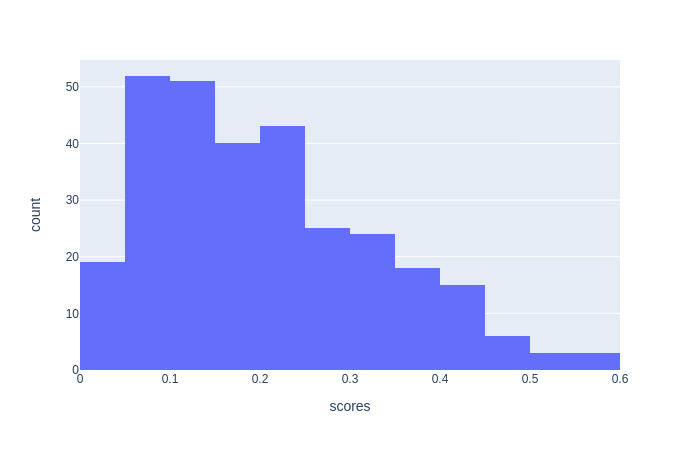

In [42]:
fig = px.histogram(df_free_scores,  x='scores')
fig.show()
# As we might expect, a lower distribution of scores when the docking isn't tethered

In [43]:
# write the scored mols as SDF
def sort_by_score(mol):
    return mol.GetDoubleProp('FeatureSteinScore')

sorted_mols = sorted(free_poses, key=sort_by_score, reverse=True)

w = Chem.SDWriter('data/FeaturesteinScore.sdf')
for mol in sorted_mols:
    w.write(mol)
w.close()

# MORE ANALYSIS NEEDED
.. but the basics seem in place

# Bigger molecules

One thing of concern is that these candidates are all not that much bigger than the hits from which they were expanded. So it may be hard for them to have much overlap with multiple fragment hits. So let's see whether you get better overalp with bigger molecules. We'll use John Chodera's poses of the Moonshot compoounds (https://github.com/FoldingAtHome/covid-moonshot/tree/master/moonshot-submissions).

In [44]:
# Read John Chodera's docked poses of moonshot compounds
gz = gzip.open('data/misc/covid_submissions_all_info-docked-overlap.sdf.gz')
supplr = Chem.ForwardSDMolSupplier(gz)
chodera_poses = []
count = 0
for m in supplr:
    chodera_poses.append(m)
    count += 1
len(chodera_poses)

4635

In [45]:
df_chodera, chodera_x_names, chodera_y_names = gen_sucos_scores(chodera_poses)

(4635, 22)
22
4635


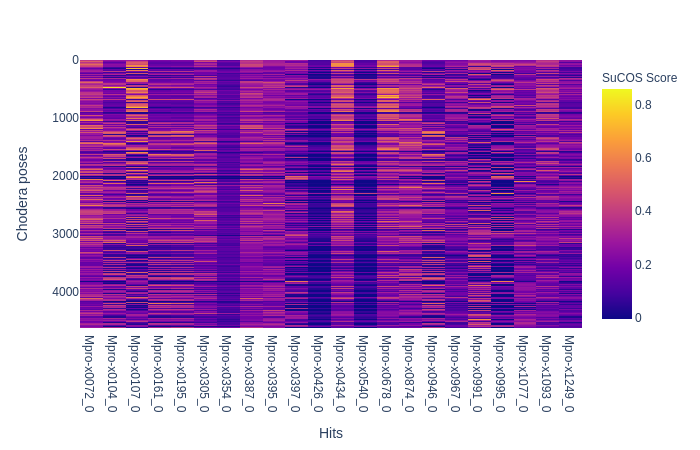

In [49]:
fig = px.imshow(df_chodera, labels=dict(x="Hits", y="Chodera poses", color="SuCOS Score"), x=chodera_x_names)
fig.show()
# reasonable overlap with most hits

In [50]:
df_fmapscores_chodera = gen_fmap_scores(chodera_poses)
df_fmapscores_chodera.shape

(4635, 1)

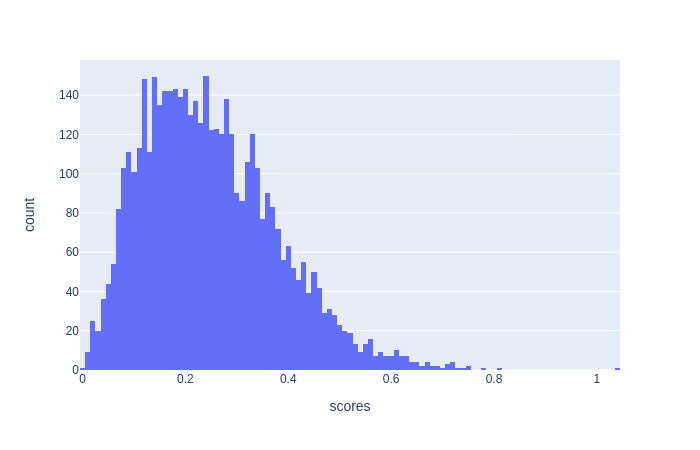

In [51]:
fig = px.histogram(df_fmapscores_chodera,  x='scores')
fig.show()
# Distribution marginally better than the fragment network hits with untethered docking?